In [39]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

from sklearn.linear_model import LinearRegression
import math

# Exercise 1:

Implement the following bounds:
1. No assumption bound
2. Monotone treatment response (MTR)
    1. nonnegative: $Y(1) \geq Y(0)$
    2. nonpositive: $Y(1) \leq Y(0)$
3. Monotone treatment selection (MTS): 
$E[Y(1) | T=1] \geq E[Y(1) | T=0]$ and 
$E[Y(0) | T=1] \geq E[Y(0) | T=0]$
4. Optimal treatment selection (OTS): 
$T_i=1 \rightarrow Y_i(1) \geq Y_i(0)$ and
$T_i=0 \rightarrow Y_i(1) < Y_i(0)$
    1. variant 1
    2. variant 2

as functions of the following parameters:
1. $a = min(Y)$
2. $b = max(Y)$
3. $\pi = P(T = 1)$
4. $E[Y | T = 1]$, $E[Y | T = 0]$

Check if you get the expected results for the following values of the input parameters:
$a=0$, $b=1$, $\pi=.3$, $E[Y | T = 1] = .9$, $E[Y | T = 0] = .2$.

Your solution:

### No asumptions bound:

Upper Bound:

$\mathbb{E} [Y(1) - Y(0)] \leq \pi \mathbb{E} [Y | T=1] + (1-\pi) b - \pi a - (1-\pi) \mathbb{E}[Y | T=0]$

Lower Bound:

$\mathbb{E} [Y(1) - Y(0)] \geq \pi \mathbb{E} [Y | T=1] + (1-\pi) a - \pi b - (1-\pi) \mathbb{E}[Y | T=0]$

For all the functions I add a boolean variable `calc`. If it is set as `True`, then it calculates the parameters `a, b, pi E_Y_cond_T_0, E_Y_cond_T_1`. If it is set as `False`, it would use the user's inputs instead.


In [41]:
def no_assump_bound(df, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=False):

  if calc==True:
    E_Y_cond_T_1 = df[df['T'] == 1]['Y'].mean()
    E_Y_cond_T_0 = df[df['T'] == 0]['Y'].mean()
    a = min(df['Y'])
    b = max(df['Y'])
    pi = len(df[df['T'] == 1]) / len(df)

  ATE = df[df['T'] == 1]['Y'].mean() - df[df['T'] == 0]['Y'].mean()
  #p_T_0 = len(df[df['T'] == 1]) / len(df)
  #a=min(df['Y']) 
  #b=max(df['Y'])
  #pi= (len(df[df['T'] == 1]) / len(df))
  #E_Y_cond_T_0=0.2
  #E_Y_cond_T_1=0.9
  # upper bound
  ub_nab =  pi * E_Y_cond_T_1 + (1 - pi) *  b - pi * a - (1 - pi) * E_Y_cond_T_0

  # lower bound
  lb_nab = pi * E_Y_cond_T_1 + (1 - pi) *  a - pi * b - (1 - pi) * E_Y_cond_T_0
  print("upper bound: ", ub_nab)
  print("lower bound: ", lb_nab)
  return(ATE <= ub_nab, ATE >= lb_nab)

### MTR:

$E[Y(1) - Y(0)] \geq 0 $

In [42]:
def MTR_bound(df, calc=False):
  if calc==True:
    E_Y_cond_T_1 = df[df['T'] == 1]['Y'].mean()
    E_Y_cond_T_0 = df[df['T'] == 0]['Y'].mean()
  ATE = df[df['T'] == 1]['Y'].mean() - df[df['T'] == 0]['Y'].mean()
  return(ATE >= 0)

### MTS: 
$E[Y(1) | T=1] \geq E[Y(1) | T=0]$ and 
$E[Y(0) | T=1] \geq E[Y(0) | T=0]$

What is the intuition behind this assumption? How can we change the model to satisfy the assumption?

What about the following modification?

This assumptions states that the treatment groups' potential outcomes are better than control groups'


<code>
"T": discrete_model(["C", "A"], { <br>
        (0, 0): (0.7, 0.3), <br>
        (0, 1): (0.1, 0.9), <br>
        (1, 0): (0.8, 0.2), <br>
        (1, 1): (0.3, 0.7), <br>
        }),
</code>

This new values of T would improve satisfaction of the assumption. We can see in the structure of the model that the treament values (`T` being 0 or 1) depends on `C` and `A`.
In the original model, observing `T=1` had smaller probabilities compared to `T=1`, while in the modified model observing `T=1` is more probable.

We can combine the two conditions of MTS as in the following:



$\mathbb{E}[Y(1) - Y(0)] \leq \mathbb{E}[Y | T=1] - \mathbb{E}[Y | T=0]$

I will implement the combined inequality in the following:

In [43]:
def MTS_bound(df, E_Y_cond_T_0, E_Y_cond_T_1, calc=False):
  if calc==True:
    E_Y_cond_T_1 = df[df['T'] == 1]['Y'].mean()
    E_Y_cond_T_0 = df[df['T'] == 0]['Y'].mean()
  ATE = df[df['T'] == 1]['Y'].mean() - df[df['T'] == 0]['Y'].mean()
  return(ATE <= E_Y_cond_T_1 - E_Y_cond_T_0)

### OTS:
$T_i=1 \rightarrow Y_i(1) \geq Y_i(0)$ and
$T_i=0 \rightarrow Y_i(1) < Y_i(0)$

What is the intuition behind this assumption? How can we change the model to satisfy the assumption?

What about the following modification?

<code>
"Y": discrete_model(["A", "T"], { <br>
        (0, 0): (0.4, 0.6), <br>
        (0, 1): (0.7, 0.3), <br>
        (1, 0): (0.9, 0.1), <br>
        (1, 1): (0.1, 0.9), <br>
        }),
</code>

The assumption implies that individuals always receive the treatment that is optimal for them. Therefore, for invidiuals in treatment group ($T_i =1$), the potential outcome under the treatment is better than the potential outcome under no treatment. Also, for individuals in no treatment group ($T_i =1$), the potential outcome under no treatment is better than the potential outcome under treatment.

The OTS bound is the following:

$\mathbb{E}[Y(1) - Y(0)] < \pi \mathbb{E}[Y | T=1] - \pi a$

$\mathbb{E}[Y(1) - Y(0)] \geq (1 - \pi)a - (1-\pi) \mathbb{E}[Y | T=0] $


I will implement the mentioned bounds in the following:

In [44]:
def OTS_bound(df, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=False):
  ATE = df[df['T'] == 1]['Y'].mean() - df[df['T'] == 0]['Y'].mean()
  if calc==True:
    E_Y_cond_T_1 = df[df['T'] == 1]['Y'].mean()
    E_Y_cond_T_0 = df[df['T'] == 0]['Y'].mean()
    a = min(df['Y'])
    b = max(df['Y'])
    pi = len(df[df['T'] == 1]) / len(df)
  #p_T_0 = len(df[df['T'] == 1]) / len(df)
  #a=min(df['Y']) 
  #b=max(df['Y'])
  #pi= (len(df[df['T'] == 1]) / len(df))
  #E_Y_cond_T_0=0.2
  #E_Y_cond_T_1=0.9
  # upper bound
  ub_ots =  pi * E_Y_cond_T_1 - pi * a
  # lower bound
  lb_ots = (1 - pi) * a - (1 - pi) * E_Y_cond_T_0 
  print("ATE avg: ", ATE)
  print("upper bound:", ub_ots)
  print("lower bound: ", lb_ots)
  return(ATE < ub_ots, ATE >= lb_ots)

# A Discrete model


True_ATE = 0.389274


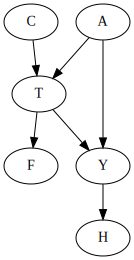

In [45]:
fd_disc = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.3, size=n_samples),
    "T": discrete_model(["C", "A"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.3, 0.7),
        (1, 1): (0.8, 0.2),
        }),  
    "F": discrete_model(["T"], {
        (0, ): (0.6, 0.4),
        (1, ): (0.1, 0.9),
        }),
    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.9, 0.1), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.4, 0.6),
        (1, 1): (0.5, 0.5),
        }),
    "H": discrete_model(["Y"], {
        (0, ): (0.2, 0.4, 0.4),
        (1, ): (0.8, 0.1, 0.1),
        }),
})
# sampling
data_df = fd_disc.sample(n_samples = 1000000)

# calculation true ATE
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('T').sample(
                    set_values={'T': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
true_ate = ab_test_df[ab_test_df['T'] == 1]['Y'].mean() - ab_test_df[ab_test_df['T'] == 0]['Y'].mean()
print('True_ATE = {}'.format(true_ate))

fd_disc.cgm.draw()

In [46]:
df_disc_0 = fd_disc.sample(n_samples=100000)

## Exercise 2:

Calculate all bounds for the discrete model defined above and check if the true causel effect is within these bounds:

In [47]:
a = 0
b = 1
pi = 0.3
E_Y_cond_T_0 = 0.2
E_Y_cond_T_1 = 0.9

### No assumption bound:

In [52]:
no_assump_bound(df_disc_0, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1)

upper bound:  0.83
lower bound:  -0.16999999999999996


(True, True)

In [50]:
no_assump_bound(df_disc_0, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=True)

upper bound:  0.6519
lower bound:  -0.34809999999999997


(True, True)

### MTR:

In [51]:
MTR_bound(df_disc_0)

True

### MTS:

In [12]:
MTS_bound(df_disc_0, E_Y_cond_T_0, E_Y_cond_T_1)

True

In [53]:
MTS_bound(df_disc_0, E_Y_cond_T_0, E_Y_cond_T_1, calc=True)

True

### OTS:

In [55]:
OTS_bound(df_disc_0, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1)

ATE avg:  0.2904732515467585
upper bound: 0.27
lower bound:  -0.13999999999999999


(False, True)

In [54]:
OTS_bound(df_disc_0, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=True)

ATE avg:  0.2904732515467585
upper bound: 0.40696
lower bound:  -0.15542


(True, True)

# Excercise 3

Start with the following model and adjust it such that OTS allows identifyng the sign of the causal effect.

Remember the logic behind each assumption.

without modification

True_ATE = 0.24940999999999997


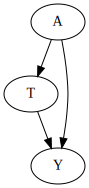

In [56]:
fd_disc = StructuralCausalModel({
    "A": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "T": discrete_model(["A"], {
        (0,): (0.6, 0.4),
        (1,): (0.4, 0.6),
        }), 
    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.4, 0.6), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.9, 0.1),
        (1, 1): (0.1, 0.9),
        }),
})
# sampling
data_df = fd_disc.sample(n_samples = 1000000)

# calculation true ATE
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('T').sample(
                    set_values={'T': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
true_ate = ab_test_df[ab_test_df['T'] == 1]['Y'].mean() - ab_test_df[ab_test_df['T'] == 0]['Y'].mean()
print('True_ATE = {}'.format(true_ate))

fd_disc.cgm.draw()

In [57]:
df_disc_1 = fd_disc.sample(n_samples=100000)

I implement the second OTS bound, which can be used for determining the sign of the ATE qunatity:

### OTS2

$\mathbb{E}[Y(1) - Y(0)] \leq \mathbb{E} [Y | T=1] - \pi a - (1 - \pi) \mathbb{E}[Y | T=0]$

$\mathbb{E}[Y(1) - Y(0)] \geq \pi \mathbb{E} [Y | T=1] + (1 - \pi) a - \mathbb{E}[Y | T=0]$

In [62]:
def OTS_bound_2(df, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=False):
  ATE = df[df['T'] == 1]['Y'].mean() - df[df['T'] == 0]['Y'].mean()

  if calc==True:
    E_Y_cond_T_1 = df[df['T'] == 1]['Y'].mean()
    E_Y_cond_T_0 = df[df['T'] == 0]['Y'].mean()
    a = min(df['Y'])
    b = max(df['Y'])
    pi = len(df[df['T'] == 1]) / len(df)
  # upper bound
  ub_ots_2 = E_Y_cond_T_1 - pi * a - (1 - pi) * E_Y_cond_T_0
  # lower bound
  lb_ots_2 = pi * E_Y_cond_T_1 + (1 - pi)*a - E_Y_cond_T_0
  print("ATE avg: ", ATE)
  print("upper bound:", ub_ots_2)
  print("lower bound: ", lb_ots_2)
  return(ATE <= ub_ots_2, ATE >= lb_ots_2)

In [63]:
OTS_bound(df_disc_1, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1,calc=True)

ATE avg:  0.2583094053280305
upper bound: 0.32842000000000005
lower bound:  -0.20095


(True, True)

In [64]:
OTS_bound_2(df_disc_1, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1,calc=True)

ATE avg:  0.2583094053280305
upper bound: 0.45798541461848685
lower bound:  -0.07220600929045629


(True, True)

After modifying

True_ATE = 0.801056


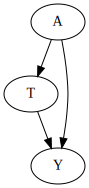

In [65]:
fd_disc = StructuralCausalModel({
    "A": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "T": discrete_model(["A"], {
        (0,): (0.6, 0.4),
        (1,): (0.4, 0.6),
        }), 
    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.9, 0.1), 
        (0, 1): (0.1, 0.9),
        (1, 0): (0.9, 0.1),
        (1, 1): (0.1, 0.9),
        }),
})
# sampling
data_df = fd_disc.sample(n_samples = 1000000)

# calculation true ATE
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('T').sample(
                    set_values={'T': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
true_ate = ab_test_df[ab_test_df['T'] == 1]['Y'].mean() - ab_test_df[ab_test_df['T'] == 0]['Y'].mean()
print('True_ATE = {}'.format(true_ate))

fd_disc.cgm.draw()

I modified the structure such that that $T_i=1 \rightarrow Y_i(1) \geq Y_i(0)$ and
$T_i=0 \rightarrow Y_i(1) < Y_i(0)$. So for the first and third rosw of cases of $Y$, corresponding to $T=0$, I increased the probability of $Y=1$ compared to $Y=0$. Moreoever, in second and fourth rows of cases of $Y$, I increased the probability of $Y=0$ compared to $Y=1$.

Your solution

In [66]:
df_disc_2 = fd_disc.sample(n_samples=100000)

In [67]:
OTS_bound(df_disc_1, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=True)

ATE avg:  0.2583094053280305
upper bound: 0.32842000000000005
lower bound:  -0.20095


(True, True)

In [68]:
OTS_bound_2(df_disc_1, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=True)

ATE avg:  0.2583094053280305
upper bound: 0.45798541461848685
lower bound:  -0.07220600929045629


(True, True)

In [69]:
OTS_bound(df_disc_2, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=True)

ATE avg:  0.7996208984650921
upper bound: 0.44980999999999993
lower bound:  -0.05041


(False, True)

In [70]:
OTS_bound_2(df_disc_2, a, b, pi, E_Y_cond_T_0, E_Y_cond_T_1, calc=True)

ATE avg:  0.7996208984650921
upper bound: 0.8499482938009167
lower bound:  0.34907260466417533


(True, True)

As we can see, after the modifications, the `OTS_bound_2` yields a positive range of bound, so using it we can determine the sign of ATE. But before modification, the lower bound of `OTS_bound_2` was negative.

